# DKASC_Alice_Springs SVM BP DNN LSTM-WDWDR

In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import tensorflow as tf
import keras
import catboost as cb
from pandas import read_csv
from math import sqrt
from numpy import concatenate
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn import svm
from keras.layers.core import Dense, Activation, Dropout
from sklearn.externals import joblib
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:469: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:470: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:472: FutureWarning: Passi

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
config = tf.ConfigProto(allow_soft_placement = True)
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.5)
config.gpu_options.allow_growth = True
sess0 = tf.InteractiveSession(config = config)

In [3]:
print(os.getcwd()) # 打印当前工作目录

E:\Research Project\DKASC, Alice Springs


In [4]:
os.listdir(os.getcwd())

['.idea',
 '.ipynb_checkpoints',
 '101-Site_DKA-WeatherStation',
 '96-Site_DKA-MasterMeter1',
 'Alice_SpringsLSTM.ipynb',
 'Alice_SpringsWPD-LSTM.ipynb',
 'Alice_Springs_2016-2020',
 'Alice_Springs数据集筛选提取.ipynb',
 'Dataset',
 'logs',
 'picture',
 'Predict',
 'Program backups',
 'temp',
 'test1-8_SVM&BP&DNN&LSTM.ipynb',
 'venv',
 'WPD.ipynb',
 '画图.ipynb',
 '相关性分析图.py',
 '笔记.ipynb',
 '训练SVM&BP&DNN&LSTM.ipynb']

In [5]:
os.chdir("./Dataset/")

In [6]:
os.listdir()

['test',
 'testdata.csv',
 'test_1A.csv',
 'train',
 'traindata.csv',
 'train_1A.csv',
 '测试集8个站点.csv',
 '训练集8个站点.csv']

In [7]:
train = pd.read_csv('train_1A.csv')
test = pd.read_csv('test_1A.csv')

In [8]:
#查看输入数据维度
print(train.shape)
print(test.shape)

(141428, 15)
(26091, 15)


In [9]:
train.head(5)

,Timestamp,Year,Month,Day,Hour,Minutes,WTC,WRH,GHR,DHR,WD,WDR,RGT,RDT,1A Trina_power
0,2018/1/19 18:30,2018,1,19,18,30,26.243799,50.889774,71.416481,67.523544,302.882996,3.6,65.268631,59.278999,0.318600
1,2018/1/19 18:35,2018,1,19,18,35,26.641783,49.539795,77.177094,71.776718,246.312622,3.6,72.546944,63.134579,0.328800
2,2018/1/19 18:40,2018,1,19,18,40,26.654078,53.414265,78.373489,69.008316,305.089630,3.6,76.711456,65.430550,0.334200
3,2018/1/19 18:45,2018,1,19,18,45,26.439108,55.582245,78.022881,67.560181,259.662933,3.6,80.445709,66.812790,0.333133
4,2018/1/19 18:50,2018,1,19,18,50,26.479477,56.173820,82.106972,73.004196,186.634705,3.6,83.035919,69.054459,0.332400


In [10]:
test.head(5)

,Timestamp,Year,Month,Day,Hour,Minutes,WTC,WRH,GHR,DHR,WD,WDR,RGT,RDT,1A Trina_power
0,2020/1/1 0:00,2020,1,1,0,0,29.685360,21.727171,1.360221,1.191879,33.216167,0.0,2.958199,0.524153,0.0
1,2020/1/1 0:05,2020,1,1,0,5,29.559967,21.878902,1.532208,1.460944,33.254341,0.0,3.288470,0.764565,0.0
2,2020/1/1 0:10,2020,1,1,0,10,29.530006,21.859453,1.186835,1.118219,33.302616,0.0,3.253541,0.725652,0.0
3,2020/1/1 0:15,2020,1,1,0,15,29.474438,21.897285,1.017349,0.824890,33.337837,0.0,3.260514,0.706365,0.0
4,2020/1/1 0:20,2020,1,1,0,20,29.365288,22.085625,1.323369,1.175776,33.375069,0.0,3.148183,0.694154,0.0


# 数据预处理训练集去异常值

In [11]:
#使用df.isnull().sum()来获得与行数None和NaN值。
train.isnull().sum()

Timestamp         0
Year              0
Month             0
Day               0
Hour              0
Minutes           0
WTC               0
WRH               0
GHR               0
DHR               0
WD                0
WDR               0
RGT               0
RDT               0
1A Trina_power    0
dtype: int64

In [12]:
test.isnull().sum()

Timestamp         0
Year              0
Month             0
Day               0
Hour              0
Minutes           0
WTC               0
WRH               0
GHR               0
DHR               0
WD                0
WDR               0
RGT               0
RDT               0
1A Trina_power    0
dtype: int64

In [13]:
# #训练集去掉全是空值的行和列    #axis=0, how='any', thresh=None, subset=None, inplace=False)
# # detectioncolumns=['WTC', 'WRH', 'GHR', 'DHR', 'WD', 'WDR', 'RGT', 'RDT']
# # for i in detectioncolumns:
# train.dropna(axis="index",how='any' , inplace=True)  #删除掉全是空值的行
# # train.dropna(axis="columns", how='all', inplace=True)  #删除掉全是空值的列


# test.dropna(axis="index", how='any', inplace=True)  #删除掉全是空值的行
# # test.dropna(axis="columns", how='all', inplace=True)  #删除掉全是空值的列

In [14]:
# #填补缺失值为均值
# #train.ffill({"RGT":train['RGT'].mean()})
# detectioncolumns=['WTC', 'WRH', 'GHR', 'DHR', 'WD', 'WDR', 'RGT', 'RDT']
# for i in detectioncolumns:
#     replace_NA=train[i].mean()
#     train[i].fillna(replace_NA,inplace=True)
# #去除测试集空值
# for i in detectioncolumns:
#     replace_NA=test[i].mean()
#     test[i].fillna(replace_NA,inplace=True)


In [15]:
train.columns

Index(['Timestamp', 'Year', 'Month', 'Day', 'Hour', 'Minutes', 'WTC', 'WRH',
       'GHR', 'DHR', 'WD', 'WDR', 'RGT', 'RDT', '1A Trina_power'],
      dtype='object')

In [16]:
test.columns

Index(['Timestamp', 'Year', 'Month', 'Day', 'Hour', 'Minutes', 'WTC', 'WRH',
       'GHR', 'DHR', 'WD', 'WDR', 'RGT', 'RDT', '1A Trina_power'],
      dtype='object')

In [17]:
train.head()

,Timestamp,Year,Month,Day,Hour,Minutes,WTC,WRH,GHR,DHR,WD,WDR,RGT,RDT,1A Trina_power
0,2018/1/19 18:30,2018,1,19,18,30,26.243799,50.889774,71.416481,67.523544,302.882996,3.6,65.268631,59.278999,0.318600
1,2018/1/19 18:35,2018,1,19,18,35,26.641783,49.539795,77.177094,71.776718,246.312622,3.6,72.546944,63.134579,0.328800
2,2018/1/19 18:40,2018,1,19,18,40,26.654078,53.414265,78.373489,69.008316,305.089630,3.6,76.711456,65.430550,0.334200
3,2018/1/19 18:45,2018,1,19,18,45,26.439108,55.582245,78.022881,67.560181,259.662933,3.6,80.445709,66.812790,0.333133
4,2018/1/19 18:50,2018,1,19,18,50,26.479477,56.173820,82.106972,73.004196,186.634705,3.6,83.035919,69.054459,0.332400


In [18]:
test.head()

,Timestamp,Year,Month,Day,Hour,Minutes,WTC,WRH,GHR,DHR,WD,WDR,RGT,RDT,1A Trina_power
0,2020/1/1 0:00,2020,1,1,0,0,29.685360,21.727171,1.360221,1.191879,33.216167,0.0,2.958199,0.524153,0.0
1,2020/1/1 0:05,2020,1,1,0,5,29.559967,21.878902,1.532208,1.460944,33.254341,0.0,3.288470,0.764565,0.0
2,2020/1/1 0:10,2020,1,1,0,10,29.530006,21.859453,1.186835,1.118219,33.302616,0.0,3.253541,0.725652,0.0
3,2020/1/1 0:15,2020,1,1,0,15,29.474438,21.897285,1.017349,0.824890,33.337837,0.0,3.260514,0.706365,0.0
4,2020/1/1 0:20,2020,1,1,0,20,29.365288,22.085625,1.323369,1.175776,33.375069,0.0,3.148183,0.694154,0.0


# keras模型训练

准备数据

In [19]:
# train1=train[['Year','Month','Day', 'Hour',
#        'Minutes','WTC', 'WRH', 'GHR', 'DHR', 'WD', 'WDR', 'RGT', 'RDT', '1A Trina_power']]
# print("查看训练集\n",train1.head())
# test1=test[['Year','Month','Day', 'Hour',
#        'Minutes','WTC', 'WRH', 'GHR', 'DHR', 'WD', 'WDR', 'RGT', 'RDT', '1A Trina_power']]
# print("查看测试集\n",test.head())
############
#去除 WD，WDR 特征
train1=train[['Year','Month','Day', 'Hour',
       'Minutes','WTC', 'WRH', 'GHR', 'DHR', 'RGT', 'RDT', '1A Trina_power']]
print("查看训练集\n",train1.head())
test1=test[['Year','Month','Day', 'Hour',
       'Minutes','WTC', 'WRH', 'GHR', 'DHR','RGT', 'RDT', '1A Trina_power']]
print("查看测试集\n",test.head())


查看训练集
    Year  Month  Day  Hour  Minutes        WTC        WRH        GHR  \
0  2018      1   19    18       30  26.243799  50.889774  71.416481   
1  2018      1   19    18       35  26.641783  49.539795  77.177094   
2  2018      1   19    18       40  26.654078  53.414265  78.373489   
3  2018      1   19    18       45  26.439108  55.582245  78.022881   
4  2018      1   19    18       50  26.479477  56.173820  82.106972   

         DHR        RGT        RDT  1A Trina_power  
0  67.523544  65.268631  59.278999        0.318600  
1  71.776718  72.546944  63.134579        0.328800  
2  69.008316  76.711456  65.430550        0.334200  
3  67.560181  80.445709  66.812790        0.333133  
4  73.004196  83.035919  69.054459        0.332400  
查看测试集
        Timestamp  Year  Month  Day  Hour  Minutes        WTC        WRH  \
0  2020/1/1 0:00  2020      1    1     0        0  29.685360  21.727171   
1  2020/1/1 0:05  2020      1    1     0        5  29.559967  21.878902   
2  2020/1/1 0:10

# 构建序列

In [20]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
#     n_vars = 1 if type(data) is list else data.shape[1]
    n_vars = list(data)
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s(t-%d)' % (j, i)) for j in n_vars]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s(t)' % (j) )for j in n_vars]
        else:
            names += [('%s(t+%d)' % (j, i)) for j in n_vars]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [21]:
train1 = series_to_supervised(train,1,2)
test1 = series_to_supervised(test,1,2)

In [22]:
# Timestamp = 

In [23]:
train1.columns

Index(['Timestamp(t-1)', 'Year(t-1)', 'Month(t-1)', 'Day(t-1)', 'Hour(t-1)',
       'Minutes(t-1)', 'WTC(t-1)', 'WRH(t-1)', 'GHR(t-1)', 'DHR(t-1)',
       'WD(t-1)', 'WDR(t-1)', 'RGT(t-1)', 'RDT(t-1)', '1A Trina_power(t-1)',
       'Timestamp(t)', 'Year(t)', 'Month(t)', 'Day(t)', 'Hour(t)',
       'Minutes(t)', 'WTC(t)', 'WRH(t)', 'GHR(t)', 'DHR(t)', 'WD(t)', 'WDR(t)',
       'RGT(t)', 'RDT(t)', '1A Trina_power(t)', 'Timestamp(t+1)', 'Year(t+1)',
       'Month(t+1)', 'Day(t+1)', 'Hour(t+1)', 'Minutes(t+1)', 'WTC(t+1)',
       'WRH(t+1)', 'GHR(t+1)', 'DHR(t+1)', 'WD(t+1)', 'WDR(t+1)', 'RGT(t+1)',
       'RDT(t+1)', '1A Trina_power(t+1)'],
      dtype='object')

In [24]:
test1.columns

Index(['Timestamp(t-1)', 'Year(t-1)', 'Month(t-1)', 'Day(t-1)', 'Hour(t-1)',
       'Minutes(t-1)', 'WTC(t-1)', 'WRH(t-1)', 'GHR(t-1)', 'DHR(t-1)',
       'WD(t-1)', 'WDR(t-1)', 'RGT(t-1)', 'RDT(t-1)', '1A Trina_power(t-1)',
       'Timestamp(t)', 'Year(t)', 'Month(t)', 'Day(t)', 'Hour(t)',
       'Minutes(t)', 'WTC(t)', 'WRH(t)', 'GHR(t)', 'DHR(t)', 'WD(t)', 'WDR(t)',
       'RGT(t)', 'RDT(t)', '1A Trina_power(t)', 'Timestamp(t+1)', 'Year(t+1)',
       'Month(t+1)', 'Day(t+1)', 'Hour(t+1)', 'Minutes(t+1)', 'WTC(t+1)',
       'WRH(t+1)', 'GHR(t+1)', 'DHR(t+1)', 'WD(t+1)', 'WDR(t+1)', 'RGT(t+1)',
       'RDT(t+1)', '1A Trina_power(t+1)'],
      dtype='object')

In [25]:
train1.drop(train1.columns[[0,1,15,16,17,18,19,20,21,22,23,24,25,26,27,28,30,31,32,33,34,35,36,37,38,39,40,41,42,43]],axis=1,inplace=True)

test1.drop(test1.columns[[0,1,15,16,17,18,19,20,21,22,23,24,25,26,27,28,30,31,32,33,34,35,36,37,38,39,40,41,42,43]],axis=1,inplace=True)

In [26]:
train1.columns

Index(['Month(t-1)', 'Day(t-1)', 'Hour(t-1)', 'Minutes(t-1)', 'WTC(t-1)',
       'WRH(t-1)', 'GHR(t-1)', 'DHR(t-1)', 'WD(t-1)', 'WDR(t-1)', 'RGT(t-1)',
       'RDT(t-1)', '1A Trina_power(t-1)', '1A Trina_power(t)',
       '1A Trina_power(t+1)'],
      dtype='object')

In [27]:
train1 = train1.values
train1 = train1.astype('float32')     # 将整型变为float
scaler = MinMaxScaler(feature_range=(0, 1)) # 数据处理，归一化至0~1之间
train1 = scaler.fit_transform(train1)

test1 = test1.values
test1 = test1.astype('float32')     # 将整型变为float
scaler = MinMaxScaler(feature_range=(0, 1)) # 数据处理，归一化至0~1之间
test1 = scaler.fit_transform(test1)

inds = np.arange(train1.shape[0])
train1_inds = inds[0:int(train1.shape[0]*0.8)]
eval1_inds = inds[int(train1.shape[0]*0.8):train1.shape[0]]


train_X, train_y = train1[train1_inds,:-1], train1[train1_inds,-1:]
eval_X,eval_y = train1[eval1_inds,:-1], train1[eval1_inds,-1:]
test_X, test_y = test1[:, :-1], test1[:,-1:]

# reshape input to be 3D [samples, timesteps, features]
train_Xl = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
eval_Xl = eval_X.reshape((eval_X.shape[0],1,eval_X.shape[1]))
test_Xl = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape,eval_X.shape,eval_y.shape, test_X.shape, test_y.shape)
print(train_Xl.shape, train_y.shape,eval_Xl.shape,eval_y.shape, test_Xl.shape, test_y.shape)

(113140, 14) (113140, 1) (28286, 14) (28286, 1) (26089, 14) (26089, 1)
(113140, 1, 14) (113140, 1) (28286, 1, 14) (28286, 1) (26089, 1, 14) (26089, 1)


# 归一化数据

In [28]:
# train1 = train1.values
# train1 = train1.astype('float32')     # 将整型变为float
# scaler = MinMaxScaler(feature_range=(0, 1)) # 数据处理，归一化至0~1之间
# train1 = scaler.fit_transform(train1)

# test1 = test1.values
# test1 = test1.astype('float32')     # 将整型变为float
# scaler = MinMaxScaler(feature_range=(0, 1)) # 数据处理，归一化至0~1之间
# test1 = scaler.fit_transform(test1)

# inds = np.arange(train1.shape[0])
# # random.shuffle(inds)
# train1_inds = inds[0:int(train1.shape[0]*0.8)]
# eval1_inds = inds[int(train1.shape[0]*0.8):train1.shape[0]]

# train_X, train_y = train1[train1_inds,1:-1], train1[train1_inds,-1:]
# #############
# train_year =train1[train1_inds,0:1]
# ##############
# eval_x,eval_y = train1[eval1_inds,1:-1], train1[eval1_inds,-1:]
# test_X, test_y = test1[:,1:-1], test1[:,-1:]
# ##############
# test_year = test1[:,0:1]
##############

In [29]:
test_y

array([[0.00330724],
       [0.00330724],
       [0.00330724],
       ...,
       [0.00330724],
       [0.00330724],
       [0.00330724]], dtype=float32)

In [30]:
print(train1)

[[0.         0.6        0.7826087  ... 0.03996861 0.0411343  0.04175143]
 [0.         0.6        0.7826087  ... 0.0411343  0.04175143 0.04162953]
 [0.         0.6        0.7826087  ... 0.04175143 0.04162953 0.04154572]
 ...
 [1.         1.0000001  1.         ... 0.00355801 0.00355801 0.00355801]
 [1.         1.0000001  1.         ... 0.00355801 0.00355801 0.00355801]
 [1.         1.0000001  1.         ... 0.00355801 0.00355801 0.00355801]]


In [31]:
print(train_X)

[[0.         0.6        0.7826087  ... 0.20160824 0.03996861 0.0411343 ]
 [0.         0.6        0.7826087  ... 0.21471684 0.0411343  0.04175143]
 [0.         0.6        0.7826087  ... 0.22252293 0.04175143 0.04162953]
 ...
 [0.27272728 0.26666668 0.9130435  ... 0.00528525 0.00355801 0.00355801]
 [0.27272728 0.26666668 0.9130435  ... 0.00463772 0.00355801 0.00355801]
 [0.27272728 0.26666668 0.9130435  ... 0.0033492  0.00355801 0.00355801]]


In [32]:
print(train_y)

[[0.04175143]
 [0.04162953]
 [0.04154572]
 ...
 [0.00355801]
 [0.00355801]
 [0.00355801]]


In [33]:
# print(train_year)

In [34]:
print(train_X.shape,train_y.shape,test_X.shape,test_y.shape)

(113140, 14) (113140, 1) (26089, 14) (26089, 1)


# SVM model

In [95]:
model=svm.SVR(C=1, cache_size=200, coef0=0.0, degree=5, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.0001, verbose=False)
model.fit(train_X, train_y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=1, cache_size=200, coef0=0.0, degree=5, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.0001, verbose=False)

In [96]:
#模型保存
modelsvm = model
joblib.dump(modelsvm, "../logs/modelsvm.m")

['../logs/modelsvm.m']

In [86]:
# #模型读取
# clf = joblib.load("train_model.m")
# clf.predit([0,0]) #此处test_X为特征集

In [87]:
# testPredictSVM=modelsvm.predict(test_X)
# print(testPredictSVM.shape())
# testPredictSVM=testPredictSVM[:, np.newaxis]
# print(testPredictSVM.shape())

# BP model

In [100]:
model=Sequential() #初始化模型
model.add(Dense(64,input_shape = (14,),activation='sigmoid',init='uniform')) #添加一个隐含层，注：只是第一个隐含层需指定input_dim
model.add(Dense(1,activation='sigmoid')) #添加输出层
model.compile(loss='mean_absolute_error', optimizer='rmsprop', metrics=['mae'])  # 编译，指定目标函数与优化方法
# model4.fit(train_X,train_y ) # 模型训练
history=model.fit(x = train_X,y = train_y, validation_data = (eval_X,eval_y), epochs=50, batch_size=1000)
model.evaluate(test_X,test_y) #模型测试

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(64, input_shape=(14,), activation="sigmoid", kernel_initializer="uniform")`
  


Train on 113140 samples, validate on 28286 samples
Epoch 1/50
113140/113140 [==============================] - 1s - loss: 0.2191 - mean_absolute_error: 0.2191 - val_loss: 0.2009 - val_mean_absolute_error: 0.2009
Epoch 2/50
113140/113140 [==============================] - 1s - loss: 0.1079 - mean_absolute_error: 0.1079 - val_loss: 0.0778 - val_mean_absolute_error: 0.0778
Epoch 3/50
113140/113140 [==============================] - 1s - loss: 0.0624 - mean_absolute_error: 0.0624 - val_loss: 0.0602 - val_mean_absolute_error: 0.0602
Epoch 4/50
113140/113140 [==============================] - 1s - loss: 0.0528 - mean_absolute_error: 0.0528 - val_loss: 0.0453 - val_mean_absolute_error: 0.0453
Epoch 5/50
113140/113140 [==============================] - 1s - loss: 0.0458 - mean_absolute_error: 0.0458 - val_loss: 0.0407 - val_mean_absolute_error: 0.0407
Epoch 6/50
113140/113140 [==============================] - 1s - loss: 0.0414 - mean_absolute_error: 0.0414 - val_loss: 0.0429 - val_mean_absolu

25632/26089 [============================>.] - ETA: 0s

[0.020529992653935167, 0.020529992653935167]

In [101]:
#模型保存
modelbp = model
modelbp.save('../logs/modelbp.h5')  

In [102]:
# #模型加载
# modelbp = load_model('../logs/modelbp.h5') 

# DNN model

In [105]:
model = Sequential()
model.add(Dense(units=64, input_shape = (14,),activation='sigmoid',name='layer1',use_bias = True))
model.add(Dense(units=32,activation='sigmoid',name='layer2',use_bias = True))
model.add(Dense(units=16,name='layer3',activation='sigmoid',use_bias = True))
model.add(Dense(units=8,name='layer4',activation='sigmoid',use_bias = True))
model.add(Dense(units=1,name='layer5',activation='sigmoid'))
model.compile(loss='mean_absolute_error',
              optimizer='rmsprop',
              metrics=['mae'])
history=model.fit(x = train_X,y = train_y, validation_data = (eval_X,eval_y), epochs=50, batch_size=1000)
############################################################################################################

Train on 113140 samples, validate on 28286 samples
Epoch 1/50
113140/113140 [==============================] - 1s - loss: 0.2853 - mean_absolute_error: 0.2853 - val_loss: 0.2922 - val_mean_absolute_error: 0.2922
Epoch 2/50
113140/113140 [==============================] - 1s - loss: 0.2279 - mean_absolute_error: 0.2279 - val_loss: 0.2686 - val_mean_absolute_error: 0.2686
Epoch 3/50
113140/113140 [==============================] - 1s - loss: 0.2027 - mean_absolute_error: 0.2027 - val_loss: 0.2173 - val_mean_absolute_error: 0.2173
Epoch 4/50
113140/113140 [==============================] - 1s - loss: 0.1228 - mean_absolute_error: 0.1228 - val_loss: 0.1309 - val_mean_absolute_error: 0.1309
Epoch 5/50
113140/113140 [==============================] - 1s - loss: 0.0752 - mean_absolute_error: 0.0752 - val_loss: 0.1080 - val_mean_absolute_error: 0.1080
Epoch 6/50
113140/113140 [==============================] - 1s - loss: 0.0607 - mean_absolute_error: 0.0607 - val_loss: 0.0957 - val_mean_absolu

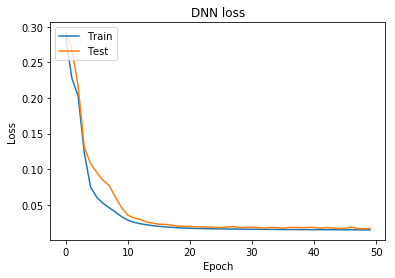

In [106]:
########################################################################
# 绘制训练 & 验证的损失值
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('DNN loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [107]:
#模型保存
modeldnn = model
modeldnn.save('../logs/modeldnn.h5')  


In [45]:
# #模型加载
# modeldnn = load_model('../logs/modeldnn.h5') 

# LSTM model

In [46]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_Xl.shape[1], train_Xl.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_Xl, train_y, epochs=50, batch_size=72, validation_data=(eval_Xl, eval_y), verbose=2, shuffle=False)


Train on 113140 samples, validate on 28286 samples
Epoch 1/50
23s - loss: 0.0257 - val_loss: 0.0231
Epoch 2/50
22s - loss: 0.0166 - val_loss: 0.0221
Epoch 3/50
23s - loss: 0.0157 - val_loss: 0.0196
Epoch 4/50
22s - loss: 0.0153 - val_loss: 0.0187
Epoch 5/50
24s - loss: 0.0148 - val_loss: 0.0195
Epoch 6/50
26s - loss: 0.0149 - val_loss: 0.0194
Epoch 7/50
26s - loss: 0.0144 - val_loss: 0.0170
Epoch 8/50
26s - loss: 0.0144 - val_loss: 0.0167
Epoch 9/50
25s - loss: 0.0143 - val_loss: 0.0165
Epoch 10/50
26s - loss: 0.0137 - val_loss: 0.0184
Epoch 11/50
28s - loss: 0.0133 - val_loss: 0.0163
Epoch 12/50
26s - loss: 0.0135 - val_loss: 0.0174
Epoch 13/50
26s - loss: 0.0135 - val_loss: 0.0171
Epoch 14/50
25s - loss: 0.0136 - val_loss: 0.0173
Epoch 15/50
26s - loss: 0.0133 - val_loss: 0.0165
Epoch 16/50
26s - loss: 0.0133 - val_loss: 0.0157
Epoch 17/50
26s - loss: 0.0133 - val_loss: 0.0157
Epoch 18/50
26s - loss: 0.0132 - val_loss: 0.0163
Epoch 19/50
26s - loss: 0.0131 - val_loss: 0.0200
Epoch 20

In [47]:
#模型保存
modellstm = model
modellstm.save('../logs/modellstm.h5')  


In [48]:
# #模型加载
# modellstm = load_model('../logs/modellstm.h5') 

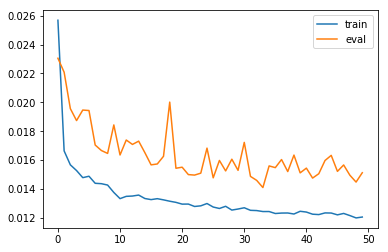

In [49]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='eval')
plt.legend()
plt.show()

In [50]:
# def inv2(testPredictML,test_X,test_y):
#     # invert scaling for forecast
#     inv_testPredictML = concatenate((test_X[:,:],testPredictML), axis=1)
#     inv_testPredictML = scaler.inverse_transform(inv_testPredictML)
#     testPredictML = inv_testPredictML[:,-1:]
#     # invert scaling for actual
#     test_y = test_y.reshape((len(test_y), 1))
#     inv_test = concatenate((test_X[:,:],test_y), axis=1)
#     inv_test = scaler.inverse_transform(inv_test)
#     testReal = inv_test[:,-1:]
#     return testPredictML,testReal

In [51]:
def inv(testPredictML,test_X,test_y):
    # invert scaling for forecast
    inv_testPredictML = concatenate((test_X[:,:],testPredictML), axis=1)
    inv_testPredictML = scaler.inverse_transform(inv_testPredictML)
    testPredictML = inv_testPredictML[:,-1:]
    # invert scaling for actual
    test_y = test_y.reshape((len(test_y), 1))
    inv_test = concatenate((test_X[:,:],test_y), axis=1)
    inv_test = scaler.inverse_transform(inv_test)
    testReal = inv_test[:,-1:]
    return testPredictML,testReal,inv_test

In [52]:
# # make a prediction
# testPredictls1 = model1.predict(test_X)
# testPredictls2 = model2.predict(test_X)


In [53]:
# test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))

# testPredictls1,testReal = inv2(testPredictls1,test_X,test_y)
# testPredictls2,testReal = inv2(testPredictls2,test_X,test_y)

In [54]:
# # calculate RMSE
# rmse = sqrt(mean_squared_error(testReal, testPredictls1))
# print('Test RMSE: %.3f' % rmse)

In [55]:
# #真实值和预测值对比图
# plt.plot(testReal,label='Real')
# plt.plot(testPredictls1,label='ls1Predicition')
# plt.plot(testPredictls2,label='ls2Predicition')
# # plt.plot(testPredictM3,label='M3Predicition')

# plt.title('Prediction test')
# plt.ylabel('Power')
# plt.xlabel('Time')
# # plt.plot(y_rr_,label='rr')
# # plt.plot(y_lasso_,label='lasso')
# plt.legend() 

# 结果对比

In [110]:
#反归一化##
def inv00(pred,A_year,A_X,A_y):
    ######训练集#######
    inv_pred = concatenate((A_year[:,:],A_X[:,:],pred), axis=1)
    inv_pred = scaler.inverse_transform(inv_pred)
    pred = inv_pred[:,-1:]
    ###### 训练集真实值######
    A_y = A_y.reshape((len(A_y), 1))
    inv_A = concatenate((A_year[:,:],A_X[:,:],A_y), axis=1)
    inv_A = scaler.inverse_transform(inv_A)
    AReal = inv_A[:,-1:]
    return pred,AReal,inv_A   

In [111]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred - y_true) / y_true)) * 100

def smape(y_true, y_pred):
    return 2.0 * np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true))) * 100

# svm

In [112]:
svm_pred = modelsvm.predict(test_X)
svm_pred = svm_pred[:, np.newaxis]
svm_pred,y_true,inv_test=inv(svm_pred,test_X,test_y)

In [113]:
svm_mse = metrics.mean_squared_error(y_true, svm_pred)
# svm_rmse = math.sqrt(mean_squared_error(y_true[:,0], svm_pred[:,0]))
svm_rmse = math.sqrt(mean_squared_error(y_true, svm_pred))
svm_mae = metrics.mean_absolute_error(y_true, svm_pred)
svm_mape = mape(y_true, svm_pred)
svm_smape = smape(y_true, svm_pred)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


In [114]:
print(svm_mse,svm_rmse,svm_mae,svm_mape,svm_smape)

0.6890419349888691 0.8300854986017219 0.7126201644299399 inf 115.76966650334823


# bp

In [115]:
bp_pred = modelbp.predict(test_X)
bp_pred,y_true,inv_test=inv(bp_pred,test_X,test_y)

bp_mse = metrics.mean_squared_error(y_true, bp_pred)
bp_rmse = math.sqrt(mean_squared_error(y_true[:,0], bp_pred[:,0]))
bp_mae = metrics.mean_absolute_error(y_true, bp_pred)
bp_mape = mape(y_true, bp_pred)
bp_smape = smape(y_true, bp_pred)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


In [116]:
print(bp_mse,bp_rmse,bp_mae,bp_mape,bp_smape)

0.21191181 0.4603388017804492 0.1870556 inf 110.4724645614624


# dnn

In [117]:
dnn_pred = modeldnn.predict(test_X)
# dnn_pred,y_true,inv_test=inv(dnn_pred,test_year,test_X,test_y)
dnn_pred,y_true,inv_test=inv(dnn_pred,test_X,test_y)

dnn_mse = metrics.mean_squared_error(y_true, dnn_pred)
dnn_rmse = math.sqrt(mean_squared_error(y_true[:,0], dnn_pred[:,0]))
dnn_mae = metrics.mean_absolute_error(y_true, dnn_pred)
dnn_mape = mape(y_true, dnn_pred)
dnn_smape = smape(y_true, dnn_pred)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


In [118]:
print(dnn_mse,dnn_rmse,dnn_mae,dnn_mape,dnn_smape)

0.18314503 0.4279544734349317 0.15583023 inf 110.53445339202881


# LSTM


In [119]:
# make a prediction
lstm_pred = modellstm.predict(test_Xl)
# test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
lstm_pred,y_true,inv_test=inv(lstm_pred,test_X,test_y)
lstm_mse = metrics.mean_squared_error(y_true, lstm_pred)
lstm_rmse = math.sqrt(mean_squared_error(y_true[:,0], lstm_pred[:,0]))
lstm_mae = metrics.mean_absolute_error(y_true, lstm_pred)
lstm_mape = mape(y_true, lstm_pred)
lstm_smape = smape(y_true, lstm_pred)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


In [120]:
print(lstm_mse,lstm_rmse,lstm_mae,lstm_mape,lstm_smape)

0.16199374 0.40248446179838515 0.1399691 inf 105.76659440994263


# 评价指标

In [121]:
#评价指标
evaluate = pd.DataFrame(columns=['Test','SVM','BP','DNN','LSTM'])

In [122]:
evaluate['Test']=['MSE','RMSE','MAE','MAPE','SMAPE']
evaluate=evaluate.set_index('Test',drop=True)

In [123]:
evaluate['SVM']=[svm_mse,svm_rmse,svm_mae,svm_mape ,svm_smape]
evaluate['BP']=[bp_mse,bp_rmse,bp_mae,bp_mape ,bp_smape]
evaluate['DNN']=[dnn_mse,dnn_rmse,dnn_mae,dnn_mape ,dnn_smape]
evaluate['LSTM']=[lstm_mse,lstm_rmse,lstm_mae,lstm_mape,lstm_smape]
evaluate

,SVM,BP,DNN,LSTM
Test,,,,
MSE,0.689042,0.211912,0.183145,0.161994
RMSE,0.830085,0.460339,0.427954,0.402484
MAE,0.712620,0.187056,0.155830,0.139969
MAPE,inf,inf,inf,inf
SMAPE,115.769667,110.472465,110.534453,105.766594


# 保存预测结果并绘图

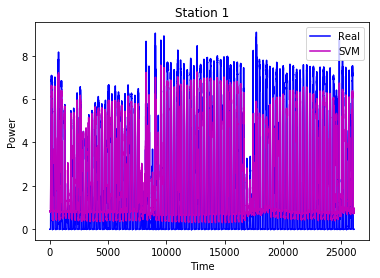

In [124]:
# from pylab import *
# mpl.rcParams['font.sans-serif'] = ['SimHei']
#真实值和预测值对比图
# plt.plot(y_true,'royalblue',label='Real')
# plt.plot(svm_pred,'orange',label='SVM')
plt.plot(y_true,'b',label='Real')
plt.plot(svm_pred,'m',label='SVM')



plt.title('Station 1')
plt.ylabel('Power')
plt.xlabel('Time')
plt.legend()
plt.savefig('../picture/SVM1.jpg')

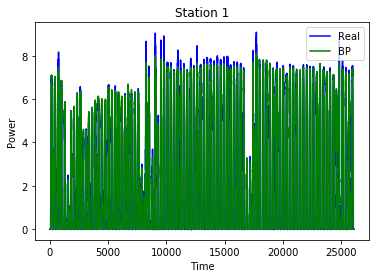

In [125]:
#真实值和预测值对比图
# plt.plot(y_true,'royalblue',label='Real')
# plt.plot(bp_pred,'limegreen',label='BP')
plt.plot(y_true,'b',label='Real')
plt.plot(bp_pred,'g',label='BP')


plt.title('Station 1')
plt.ylabel('Power')
plt.xlabel('Time')
plt.legend()
plt.savefig('../picture/BP1.jpg')

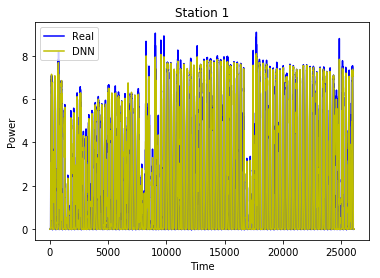

In [126]:
#真实值和预测值对比图
# plt.plot(y_true,'royalblue',label='Real')
# plt.plot(dnn_pred,'tomato',label='DNN')
plt.plot(y_true,'b',label='Real')
plt.plot(dnn_pred,'y',label='DNN')


plt.title('Station 1')
plt.ylabel('Power')
plt.xlabel('Time')
plt.legend()
plt.savefig('../picture/DNN1.jpg')

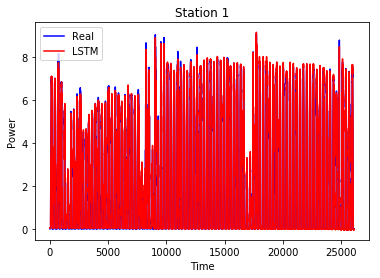

In [127]:
#真实值和预测值对比图

# plt.plot(lstm_pred,'orchid',label='LSTM')
plt.plot(y_true,'b',label='Real')
plt.plot(lstm_pred,'r',label='LSTM')

plt.title('Station 1')
plt.ylabel('Power')
plt.xlabel('Time')
plt.legend()
plt.savefig('../picture/LSTM1.jpg')

# 保存

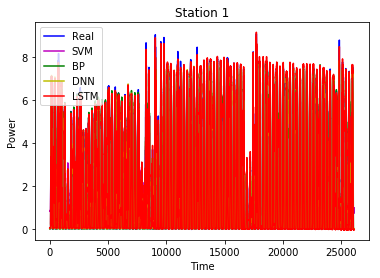

In [128]:

#真实值和预测值对比图
plt.plot(y_true,'b',label='Real')
plt.plot(svm_pred,'m',label='SVM')
plt.plot(bp_pred,'g',label='BP')
plt.plot(dnn_pred,'y',label='DNN')
plt.plot(lstm_pred,'r',label='LSTM')

plt.title('Station 1')
plt.ylabel('Power')
plt.xlabel('Time')
plt.legend()
plt.savefig('../picture/SVMLSTM1.jpg')

#训练集和测试集 预测结果保存
predict_ = pd.DataFrame(inv_test)
# predict_.columns = ['Year', 'Month', 'Day', 'Hour', 'Minutes', 'WTC', 'WRH', 'GHR', 'DHR',
#        'RGT', 'RDT', '1A Trina_power']
predict_.columns = ['Month(t-1)', 'Day(t-1)', 'Hour(t-1)', 'Minutes(t-1)', 'WTC(t-1)',
       'WRH(t-1)', 'GHR(t-1)', 'DHR(t-1)', 'WD(t-1)', 'WDR(t-1)', 'RGT(t-1)',
       'RDT(t-1)', '1A Trina_power(t-1)', '1A Trina_power(t)',
       '1A Trina_power(t+1)']
predict_['SVM'] = svm_pred
predict_['BP'] = bp_pred
predict_['DNN'] = dnn_pred
predict_['LSTM'] = lstm_pred
predict_.to_csv('../predict/1Atest_pred_-WDWDR_svm&bp&dnn.csv',index=False)


画出例如2020年1月20号的预测图

In [129]:
predict_.columns

Index(['Month(t-1)', 'Day(t-1)', 'Hour(t-1)', 'Minutes(t-1)', 'WTC(t-1)',
       'WRH(t-1)', 'GHR(t-1)', 'DHR(t-1)', 'WD(t-1)', 'WDR(t-1)', 'RGT(t-1)',
       'RDT(t-1)', '1A Trina_power(t-1)', '1A Trina_power(t)',
       '1A Trina_power(t+1)', 'SVM', 'BP', 'DNN', 'LSTM'],
      dtype='object')

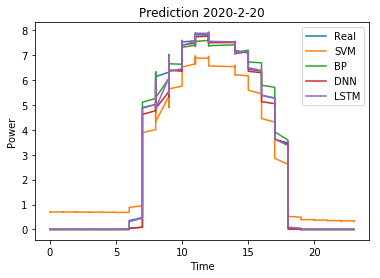

In [130]:
# from scipy.interpolate import spline
predict_[['Month(t-1)', 'Day(t-1)', 'Hour(t-1)', 'Minutes(t-1)']] = predict_[['Month(t-1)', 'Day(t-1)', 'Hour(t-1)', 'Minutes(t-1)']].astype("int")

# Day0120 = predict_.loc[(predict_['Year'] == 2020) & (predict_['Month'] == ) & (predict_['Day'] == 20),:]
Day0120 = predict_.loc[(predict_['Month(t-1)'] == 2 ) & (predict_['Day(t-1)'] == 20),:]
#real_power_day.set_index('time', inplace=False)
Real=Day0120.set_index('Hour(t-1)', inplace=False)['1A Trina_power(t+1)']
svm_pr=Day0120.set_index('Hour(t-1)', inplace=False)['SVM']
bp_pr=Day0120.set_index('Hour(t-1)', inplace=False)['BP']
dnn_pr=Day0120.set_index('Hour(t-1)', inplace=False)['DNN']
lstm_pr=Day0120.set_index('Hour(t-1)', inplace=False)['LSTM']

fig = plt.figure()
plt.plot(Real,label='Real')
plt.plot(svm_pr,label='SVM')
plt.plot(bp_pr,label='BP')
plt.plot(dnn_pr,label='DNN')
plt.plot(lstm_pr,label='LSTM')

plt.title('Prediction 2020-2-20')
plt.ylabel('Power')
plt.xlabel('Time')
# plt.legend(['Train', 'Test'], loc='upper left')
plt.legend()
plt.savefig('../picture/2-20pred.jpg')
#ax = fig.add_subplot(1,1,1)
#ax.plot(real_power_day_)
# real_power_day_.plot()
#real_power_day_.set_axis(['00:15:00','06:15:00','12:15:00','18:15:00'])
#real_power_day_

# 2020 

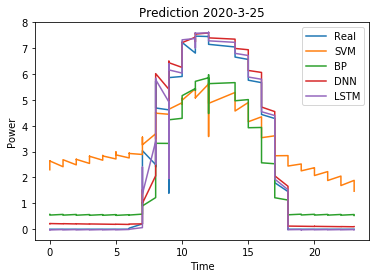

In [77]:
# from scipy.interpolate import spline
predict_[['Month(t-1)', 'Day(t-1)', 'Hour(t-1)', 'Minutes(t-1)']] = predict_[['Month(t-1)', 'Day(t-1)', 'Hour(t-1)', 'Minutes(t-1)']].astype("int")

# Day0120 = predict_.loc[(predict_['Year'] == 2020) & (predict_['Month'] == ) & (predict_['Day'] == 20),:]
Day0120 = predict_.loc[(predict_['Month(t-1)'] == 3 ) & (predict_['Day(t-1)'] == 25),:]
#real_power_day.set_index('time', inplace=False)
Real=Day0120.set_index('Hour(t-1)', inplace=False)['1A Trina_power(t+1)']
svm_pr=Day0120.set_index('Hour(t-1)', inplace=False)['SVM']
bp_pr=Day0120.set_index('Hour(t-1)', inplace=False)['BP']
dnn_pr=Day0120.set_index('Hour(t-1)', inplace=False)['DNN']
lstm_pr=Day0120.set_index('Hour(t-1)', inplace=False)['LSTM']

fig = plt.figure()
plt.plot(Real,label='Real')
plt.plot(svm_pr,label='SVM')
plt.plot(bp_pr,label='BP')
plt.plot(dnn_pr,label='DNN')
plt.plot(lstm_pr,label='LSTM')

plt.title('Prediction 2020-3-25')
plt.ylabel('Power')
plt.xlabel('Time')
# plt.legend(['Train', 'Test'], loc='upper left')
plt.legend()
plt.savefig('../picture/3-25pred.jpg')
#ax = fig.add_subplot(1,1,1)
#ax.plot(real_power_day_)
# real_power_day_.plot()
#real_power_day_.set_axis(['00:15:00','06:15:00','12:15:00','18:15:00'])
#real_power_day_